In [1]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.llama_dataset.generator import RagDatasetGenerator
from llama_index.llms.openai import OpenAI
from llama_index.core.evaluation import (
    BatchEvalRunner,
    CorrectnessEvaluator,
    FaithfulnessEvaluator,
    RelevancyEvaluator
)
from llama_index.core import VectorStoreIndex, StorageContext,load_index_from_storage

# Evaluation Metrics for Language Models

When evaluating the performance of language models, several key metrics are used to assess different aspects of the generated responses. Below are explanations of three crucial metrics: correctness, faithfulness, and relevancy, along with illustrative formulas.

## Correctness

**Correctness** measures the accuracy of the information provided in the model's response. It evaluates whether the response is factually accurate and free from errors.

### Formula

The correctness of a response can be quantified using a simple accuracy formula:

\[ \text{Correctness} = \frac{\text{Number of Correct Facts}}{\text{Total Number of Facts in Response}} \]

### Example

- **Question:** "What is the capital of France?"
- **Correct Response:** "The capital of France is Paris."

If the response contains 3 facts, and 2 of them are correct, the correctness score would be:

\[ \text{Correctness} = \frac{2}{3} = 0.67 \]

### Importance

Ensuring that the model provides accurate information is essential, especially in applications where reliability and precision are critical, such as in educational tools or medical advice systems.

## Faithfulness

**Faithfulness** assesses whether the model's response stays true to the given input, without introducing any hallucinations or fabrications.

### Formula

Faithfulness can be assessed by comparing the overlap between the facts in the input and the response:

\[ \text{Faithfulness} = \frac{\text{Number of Consistent Facts with Input}}{\text{Total Number of Facts in Response}} \]

### Example

- **Input:** "The Eiffel Tower is located in Paris."
- **Faithful Response:** "The Eiffel Tower, which is in Paris, is a famous landmark."

If the response contains 3 facts and all 3 are consistent with the input, the faithfulness score would be:

\[ \text{Faithfulness} = \frac{3}{3} = 1.0 \]

### Importance

Faithfulness is crucial in maintaining trust in the model's outputs, ensuring that responses are based on the provided input and not on made-up information.

## Relevancy

**Relevancy** measures how pertinent\relevant the model's response is to the user's query. It evaluates whether the response directly addresses the question or topic posed by the user.

### Formula

Relevancy can be quantified using the cosine similarity between the query and response embeddings:

\[ \text{Relevancy} = \cos(\theta) = \frac{\vec{Q} \cdot \vec{R}}{\|\vec{Q}\| \|\vec{R}\|} \]

where:
- \(\vec{Q}\) is the vector representation of the query.
- \(\vec{R}\) is the vector representation of the response.

### Example

- **Query:** "What are the health benefits of apples?"
- **Relevant Response:** "Apples are nutritious and may help reduce the risk of several diseases."

If the cosine similarity between the query and response vectors is 0.85, the relevancy score would be:

\[ \text{Relevancy} = 0.85 \]

### Importance

Relevancy ensures that the model's responses are useful and focused on the user's needs, improving the overall user experience and satisfaction.

## Conclusion

Correctness, faithfulness, and relevancy are critical metrics for evaluating the performance of language models. Together, they ensure that the model provides accurate, trustworthy, and useful responses, enhancing the overall effectiveness and reliability of the system.

By understanding and applying these metrics, developers and researchers can better assess and improve their language models, leading to more robust and user-friendly applications.

For further reading and detailed methodologies, refer to [LlamaIndex Documentation](https://docs.llamaindex.ai).



In [47]:
# ref
# https://github.com/rokbenko/ai-playground/blob/main/llamaindex-tutorials/3-Eval_travel_recommendation_RAG/travel_recommendation_rag_eval.py

In [2]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

In [3]:
# Define the directory where the storage context is persisted
persist_dir = "./storage/cache_2/company_abstract/"  # replace with your actual directory

# Load the storage context
storage_context = StorageContext.from_defaults(persist_dir=persist_dir)

# Initialize the index with the loaded storage context
#index = VectorStoreIndex([], storage_context=storage_context)
index = load_index_from_storage(storage_context)

# Access all documents in the index
all_documents = list(list(storage_context.docstore.docs.values()))

In [35]:
# all_documents[:10]

In [4]:
dataset_generator = RagDatasetGenerator.from_documents(
    documents = all_documents[:15],
    llm = OpenAI(
        model = "gpt-3.5-turbo",
        #api_key = st.secrets["OPENAI_API_KEY"]
    )
)

In [5]:
eval_questions = dataset_generator.generate_dataset_from_nodes()

In [6]:
# Initialize the OpenAI model
openai_model = OpenAI(
    system_prompt = "You are a helpful travel assistant. When asked a question, answer from the data directory. \
        If you don't know the answer, say 'Nothing found in documents'",
    model = "gpt-3.5-turbo",
    max_tokens = 250
)

In [7]:
# Initialize the evaluators
correctness_evaluator = CorrectnessEvaluator(llm = openai_model) # Useful for measuring if the response is correct against a reference answer
faithfulness_evaluator = FaithfulnessEvaluator(llm = openai_model) # Useful for measuring if the response is hallucinated
relevancy_evaluator = RelevancyEvaluator(llm = openai_model) # Useful for measuring if the query is actually answered by the response

In [8]:
eval_questions.examples[2]

LabelledRagDataExample(query='Can you provide the registration number of DAVOR and the year it was established?', query_by=CreatedBy(model_name='gpt-3.5-turbo', type=<CreatedByType.AI: 'ai'>), reference_contexts=["Adresa : Kutina, Podravska 1,\nNaziv_subjekta : DAVOR,\nPodnaslov_subjekta : DAVOR, limarski obrt, vl. Davor Kolobara, Kutina, Podravska ulica 1\\nTijelo : -,\nGodina osnivanja : 2013,\nRegistracijski broj : 97417378,\nDjelatnost : 43.91 Radovi na krovištu (NKD 2007),\nodgovorna_osoba : {'ime': 'Davor Kolobara', 'rola': 'vlasnik'}\n\ntitle : DAVOR, limarski obrt, vl. Davor Kolobara, Kutina, Podravska ulica 1,\nhref : https://www.poslovna.hr/lite/davor/1333513/subjekti.aspx,\nbody : DAVOR , Kutina Djelatnost: radovi na krovištu. Prihodi, dobit, bilanca, prikaz poslovanja za DAVOR , Kutina..."], reference_answer='The registration number of DAVOR is 97417378 and it was established in 2013.', reference_answer_by=CreatedBy(model_name='gpt-3.5-turbo', type=<CreatedByType.AI: 'ai'>)

In [9]:
[question.query for question in eval_questions.examples][:3]

['What is the name of the business and who is the owner of the company DAVOR located in Kutina?',
 'What is the main activity of DAVOR according to the NKD 2007 classification?',
 'Can you provide the registration number of DAVOR and the year it was established?']

In [10]:
index.as_query_engine().query('Who is the owner of the company DAVOR, a sheet metal craft business located in Kutina at Podravska ulica 1?').response

'The owner of the company DAVOR, a sheet metal craft business located in Kutina at Podravska ulica 1, is Davor Kolobara.'

In [11]:
# Define an asynchronous function for evaluation
async def evaluate_async(index):
    # Initialize the BatchEvalRunner
    runner = BatchEvalRunner(
        {
            "correctness": correctness_evaluator,
            "faithfulness": faithfulness_evaluator,
            "relevancy": relevancy_evaluator
        },
        show_progress = True
    )

    # Run the asynchronous evaluation
    eval_result = await runner.aevaluate_queries(
        query_engine = index.as_query_engine(),
        queries = [question.query for question in eval_questions.examples]
    )

    return eval_result

In [13]:
# Run the asynchronous function using asyncio
result = asyncio.run(evaluate_async(index))

100%|██████████| 135/135 [00:48<00:00,  2.81it/s]


In [15]:
import pandas as pd

In [16]:
# Extract relevant information from the evaluation results
data = []
for i, question in enumerate(eval_questions.examples):
    correctness_result = result['correctness'][i]
    faithfulness_result = result['faithfulness'][i]
    relevancy_result = result['relevancy'][i]
    data.append({
        'Query': question.query,
        'Correctness response': correctness_result.response,
        'Correctness passing': correctness_result.passing,
        'Correctness feedback': correctness_result.feedback,
        'Correctness score': correctness_result.score,
        'Faithfulness response': faithfulness_result.response,
        'Faithfulness passing': faithfulness_result.passing,
        'Faithfulness feedback': faithfulness_result.feedback,
        'Faithfulness score': faithfulness_result.score,
        'Relevancy response': relevancy_result.response,
        'Relevancy passing': relevancy_result.passing,
        'Relevancy feedback': relevancy_result.feedback,
        'Relevancy score': relevancy_result.score,
    })

# Create a pandas DataFrame
df = pd.DataFrame(data)
df["model"] = "gpt3.5turbo + svs"

In [17]:
# df

df.to_excel('outputs/evaluation/eval_report2.xlsx', sheet_name = 'eval_results', index = False)

In [18]:
df.to_csv('outputs/evaluation/eval_report2.csv', header=True, sep="|", index = False)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def visualize_avg_scores(df):
    # Read the CSV data into a DataFrame
    # Calculate the average scores for each metric
    avg_correctness = df['Correctness score'].mean()
    avg_faithfulness = df['Faithfulness score'].mean()
    avg_relevancy = df['Relevancy score'].mean()

    # Create a DataFrame for the average scores
    avg_scores = pd.DataFrame({
        'Metric': ['Correctness', 'Faithfulness', 'Relevancy'],
        'Average Score': [avg_correctness, avg_faithfulness, avg_relevancy]
    })

    # Set up the seaborn style
    sns.set(style="whitegrid")

    # Plot the average scores
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Metric', y='Average Score', data=avg_scores, palette=['blue', 'green', 'orange'])

    # Add labels on top of each bar
    for index, row in avg_scores.iterrows():
        barplot.text(index, row['Average Score'] + 0.05, round(row['Average Score'], 2), color='black', ha="center")

    # Set the title and labels
    plt.title('Average Scores for Each Metric')
    plt.xlabel('Metric')
    plt.ylabel('Average Score')
    plt.ylim(0, 5)
    plt.show()

C:\Users\mpavisic\AppData\Local\Temp\ipykernel_16392\2605340838.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Metric', y='Average Score', data=avg_scores, palette=['blue', 'green', 'orange'])


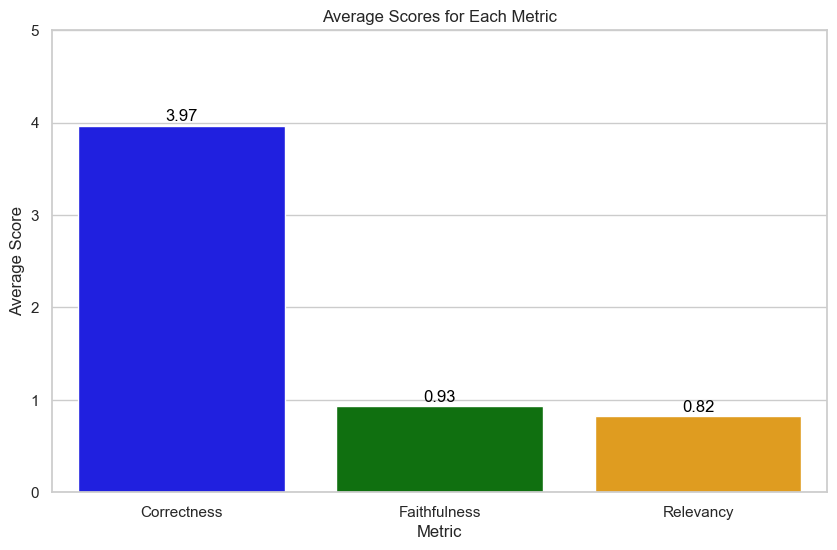

In [21]:
v = visualize_avg_scores(df)